# USA Water Systems and Operators

## References

|Link|Notes|
|---|---|
|https://www.bls.gov/cew/downloadable-data-files.htm|County-level labor statistics|


## Imports and Setup

In [57]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from fuzzywuzzy import fuzz, process
from mpl_toolkits.axes_grid1 import make_axes_locatable
import fiona as fiona
from ipypb import track
from textwrap3 import wrap
import matplotlib as mpl

In [2]:
pd.options.display.max_columns = 999

## Data

In [3]:
folder_WaterSystems = "C:\\Users\\garfink2\\Documents\\data\\drinkingwater\\watersystems"
csv_FacilityFiles = "C:\\Users\\garfink2\\Documents\\data\\drinkingwater\\national_combined\\NATIONAL_FACILITY_FILE.CSV"
shp_USCounties = "C:\\Users\\garfink2\\Documents\\data\\basemap\\tl_2017_us_county\\tl_2017_us_county.shp"
shp_USStates = "C:\\Users\\garfink2\\Documents\\data\\basemap\\tl_2017_us_state\\tl_2017_us_state.shp"
excel_StateFPCodes = "C:\\Users\\garfink2\\Documents\\data\\basemap\\statefpcodes.xlsx"
excel_BLSIndustries = "C:\\Users\\garfink2\\Documents\\data\\bls\\Copy of industry_titles.xlsx"
csv_EmployementData2019Q1 = "C:\\Users\\garfink2\\Documents\\data\\bls\\2019_qtrly_singlefile\\2019.q1-q3.singlefile.csv"
csv_EmploymentData2018 = "C:\\Users\\garfink2\\Documents\\data\\bls\\2018_annual_singlefile\\2018.annual.singlefile.csv"
gdbPath = r"C:\Users\garfink2\Documents\data\infrastructure\ArmyWide_CIP_Repository_Extract_SDSFIE_4_0_2_20191209.gdb"

## Analyses

### Water Treatment Systems

In [4]:
list_StateFiles = os.listdir(folder_WaterSystems)

In [5]:
dict_StateFiles = {}
for stateFile in list_StateFiles:
    df = pd.read_csv(f"{folder_WaterSystems}/{stateFile}",encoding='cp1252')
    df["State"] = stateFile.split('.')[0].upper()
    dict_StateFiles[stateFile.split('.')[0].upper()] = df

In [6]:
df_AllStateWaterSupplies = pd.concat(list(dict_StateFiles.values()))

### National Facilities

In [7]:
nationalFacilities = pd.read_csv(csv_FacilityFiles)

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (4,7,11,12,13,14,15,16,21,23,24,31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
nationalFacilities.head()

,FRS_FACILITY_DETAIL_REPORT_URL,REGISTRY_ID,PRIMARY_NAME,LOCATION_ADDRESS,SUPPLEMENTAL_LOCATION,CITY_NAME,COUNTY_NAME,FIPS_CODE,STATE_CODE,STATE_NAME,COUNTRY_NAME,POSTAL_CODE,FEDERAL_FACILITY_CODE,FEDERAL_AGENCY_NAME,TRIBAL_LAND_CODE,TRIBAL_LAND_NAME,CONGRESSIONAL_DIST_NUM,CENSUS_BLOCK_CODE,HUC_CODE,EPA_REGION_CODE,SITE_TYPE_NAME,LOCATION_DESCRIPTION,CREATE_DATE,UPDATE_DATE,US_MEXICO_BORDER_IND,PGM_SYS_ACRNMS,LATITUDE83,LONGITUDE83,CONVEYOR,COLLECT_DESC,ACCURACY_VALUE,REF_POINT_DESC,HDATUM_DESC,SOURCE_DESC
0,http://ofmpub.epa.gov/enviro/fii_query_detail....,110000491735,OCEAN DOCK TERMINAL AND ANCHORAGE TERMINAL II,1076 OCEAN DOCK RD,NaN,ANCHORAGE,ANCHORAGE,02020,AK,ALASKA,UNITED STATES,99501,NaN,NaN,NaN,NaN,NaN,2.020001e+13,19020401.0,10.0,STATIONARY,NaN,01-MAR-2000 00:00:00,11-DEC-2018 15:13:31,NaN,"AIR:AK0000000202000032, AIRS/AFS:0202000032, B...",61.229579,-149.893094,EPA_SLT,INTERPOLATION-PHOTO,125.0,FACILITY CENTROID,NAD83,NaN
1,http://ofmpub.epa.gov/enviro/fii_query_detail....,110000491744,INLET PERTROLEUM ANCHORAGE,459 W BLUFF DR,NaN,ANCHORAGE,ANCHORAGE,02020,AK,ALASKA,UNITED STATES,99501,NaN,NaN,NaN,NaN,00,2.020000e+13,19020401.0,10.0,STATIONARY,NaN,01-MAR-2000 00:00:00,01-JUN-2017 17:14:03,NaN,"EIS:677611, ICIS:2600029860, ICIS:5870869, NPD...",61.231236,-149.888143,EPA_SLT,INTERPOLATION-PHOTO,3.0,FACILITY CENTROID,NAD83,NaN
2,http://ofmpub.epa.gov/enviro/fii_query_detail....,110000491762,UNIVAR USA,590 E 100TH AVE,NaN,ANCHORAGE,ANCHORAGE,02020,AK,ALASKA,UNITED STATES,99515,NaN,NaN,NaN,NaN,00,2.020003e+13,19020401.0,10.0,STATIONARY,NaN,01-MAR-2000 00:00:00,25-MAY-2016 12:31:49,NaN,"AIR:AK0000000202000105, BR:AKD981765902, EIS:6...",61.129407,-149.871824,EPA_SLT,INTERPOLATION-PHOTO,3.0,FACILITY CENTROID,NAD83,NaN
3,http://ofmpub.epa.gov/enviro/fii_query_detail....,110000491780,FAIRBANKS PETROLEUM TERMINAL,5500 AIRPORT INDUSTRIAL RD,NaN,FAIRBANKS,FAIRBANKS NORTH STAR,02090,AK,ALASKA,UNITED STATES,99709,NaN,NaN,NaN,NaN,00,2.090001e+13,19040506.0,10.0,STATIONARY,NaN,01-MAR-2000 00:00:00,16-APR-2018 14:29:45,NaN,"EIS:680011, ICIS:600007563, NPDES:AKR06AB58, N...",64.811292,-147.884914,EPA_SLT,INTERPOLATION-PHOTO,3.0,FACILITY CENTROID,NAD83,NaN
4,http://ofmpub.epa.gov/enviro/fii_query_detail....,110000491824,TESORO ALASKA KETCHIKAN TERMINAL,1010 STEDMAN ST,NaN,KETCHIKAN,KETCHIKAN GATEWAY,02130,AK,ALASKA,UNITED STATES,99901,NaN,NaN,Yes,NaN,00,2.130000e+13,19010102.0,10.0,STATIONARY,NaN,01-MAR-2000 00:00:00,01-JUN-2017 17:14:03,NaN,"EIS:540611, NPDES:AK0000523, RCRAINFO:AKD09983...",55.335010,-131.627950,FRS-TRIS,ADDRESS MATCHING-HOUSE NUMBER,30.0,CENTER OF A FACILITY OR STATION,NAD83,NaN


In [9]:
nationalFacilities.columns

Index(['FRS_FACILITY_DETAIL_REPORT_URL', 'REGISTRY_ID', 'PRIMARY_NAME',
       'LOCATION_ADDRESS', 'SUPPLEMENTAL_LOCATION', 'CITY_NAME', 'COUNTY_NAME',
       'FIPS_CODE', 'STATE_CODE', 'STATE_NAME', 'COUNTRY_NAME', 'POSTAL_CODE',
       'FEDERAL_FACILITY_CODE', 'FEDERAL_AGENCY_NAME', 'TRIBAL_LAND_CODE',
       'TRIBAL_LAND_NAME', 'CONGRESSIONAL_DIST_NUM', 'CENSUS_BLOCK_CODE',
       'HUC_CODE', 'EPA_REGION_CODE', 'SITE_TYPE_NAME', 'LOCATION_DESCRIPTION',
       'CREATE_DATE', 'UPDATE_DATE', 'US_MEXICO_BORDER_IND', 'PGM_SYS_ACRNMS',
       'LATITUDE83', 'LONGITUDE83', 'CONVEYOR', 'COLLECT_DESC',
       'ACCURACY_VALUE', 'REF_POINT_DESC', 'HDATUM_DESC', 'SOURCE_DESC'],
      dtype='object')

In [10]:
nationalFacilities["FRS_FACILITY_DETAIL_REPORT_URL"][1]

'http://ofmpub.epa.gov/enviro/fii_query_detail.disp_program_facility?p_registry_id=110000491744'

In [11]:
nationalFacilities["HUC_CODE"]

0          19020401.0
1          19020401.0
2          19020401.0
3          19040506.0
4          19010102.0
              ...    
4224068           NaN
4224069           NaN
4224070           NaN
4224071           NaN
4224072           NaN
Name: HUC_CODE, Length: 4224073, dtype: float64

### Basemap Data

US Counties

In [12]:
gdf_USCounties = gpd.read_file(shp_USCounties)

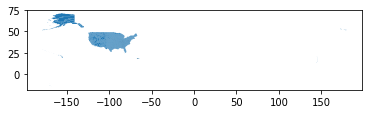

In [13]:
gdf_USCounties.plot()

In [14]:
gdf_USCounties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477641638,10701538,+41.9158651,-096.7885168,"POLYGON ((-97.01952 42.00410, -97.01952 42.004..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680956787,61588406,+46.2946377,-123.4244583,"POLYGON ((-123.43639 46.23820, -123.44759 46.2..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016761648,29147345,+34.3592729,-104.3686961,"POLYGON ((-104.56739 33.99757, -104.56772 33.9..."
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169252486,22867561,+40.7835474,-096.6886584,"POLYGON ((-96.91060 40.95841, -96.91060 40.958..."
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645186,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27367 40.08940, -98.27367 40.089..."


US States

In [15]:
gdf_USStates = gpd.read_file(shp_USStates)

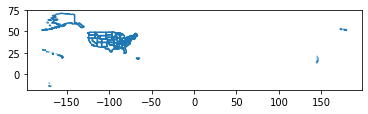

In [16]:
gdf_USStates.boundary.plot()

Overlay locations of Army Installations

In [17]:
def readGDB(gdbPath,layersToRead=None):
    dfs = {}
    if not layersToRead:
        layers = fiona.listlayers(gdbPath)
    else:
        layers = layersToRead
    nFailed = 0
    for l in track(layers):
        try:
            df = gpd.read_file(gdbPath, driver='FileGDB', layer=l)
            dfs[l] = df
        except:
            dfs[l] = "FAILED"
            nFailed += 1
            print(f"Layer: {l} FAILED")
    print(f"Processed {len(layers)} layers, with {nFailed} failures.")
    return dfs

In [18]:
layersToRead = ['Installation_A']

In [19]:
dict_installations = readGDB(gdbPath,layersToRead=layersToRead)

 [████████████████████████████████████████████████████████████] 1/1 [00:00<00:00, 0.22s/it]

Processed 1 layers, with 0 failures.


In [20]:
installationAreas = dict_installations["Installation_A"]

Reproject

In [21]:
installationAreas = installationAreas.to_crs(gdf_USCounties.crs['init'])

### Map water systems to US counties

In [22]:
df_StateFPCodes = pd.read_excel(excel_StateFPCodes)

In [23]:
df_StateFPCodes

,Name,Postal Code,FIPS
0,Alabama,AL,1
1,Alaska,AK,2
2,Arizona,AZ,4
3,Arkansas,AR,5
4,California,CA,6
5,Colorado,CO,8
6,Connecticut,CT,9
7,Delaware,DE,10
8,Florida,FL,12
9,Georgia,GA,13


In [24]:
df_AllStateWaterSupplies = pd.merge(left=df_AllStateWaterSupplies,right=df_StateFPCodes,left_on="State",right_on="Postal Code")

In [25]:
df_AllStateWaterSupplies

,PWS ID,PWS Name,PWS Type,Primary Source,Counties Served,Cities Served,PopulationServed Count,Number of Facilities,Number of Violations,Number of Site Visits,State,Name,Postal Code,FIPS
0,AK2260595,ADAK UTILITIES,Community water system,Surface water,Aleutians West Census Area,ADAK,325,9,513,10,AK,Alaska,AK,2
1,AK2250037,AKHIOK,Community water system,Surface water,Kodiak Island Borough,AKHIOK,90,6,1175,8,AK,Alaska,AK,2
2,AK2272747,AKIACHAK WATER SYSTEM,Community water system,Ground water,Bethel Census Area,AKIACHAK,627,6,147,4,AK,Alaska,AK,2
3,AK2272005,AKIAK COMMUNITY WATER SYSTEM,Community water system,Ground water,Bethel Census Area,AKIAK,346,6,489,4,AK,Alaska,AK,2
4,AK2260252,AKUTAN,Community water system,Surface water,Aleutians East Borough,AKUTAN,95,6,572,8,AK,Alaska,AK,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143884,WY5680086,YELLOWSTONE NP-PEBBLE CREEK CG,Transient non-community system,Ground water,Park,YELLOWSTONE NP,100,10,3,9,WY,Wyoming,WY,56
143885,WY5680152,YELLOWSTONE NP-SLOUGH CREEK CG,Transient non-community system,Ground water,Park,YELLOWSTONE NP,94,10,4,7,WY,Wyoming,WY,56
143886,WY5680089,YELLOWSTONE NP-TOWER FALL CG,Transient non-community system,Ground water,Park,YELLOWSTONE NP,495,6,1,9,WY,Wyoming,WY,56
143887,WY5600471,YELLOWSTONE VALLEY INN,Transient non-community system,Ground water,Park,CODY,315,6,23,7,WY,Wyoming,WY,56


Kludge- make the decision to assign water systems to the first county in their list so that I'm not multiple-counting staffing

In [26]:
nCountiesServed = {}
list_NCountiesServed = []
list_FirstCountiesServed = []
for i,row in df_AllStateWaterSupplies.iterrows():
    counties = row["Counties Served"].split(",")
    nCounties = len(counties)
    list_NCountiesServed.append(nCounties)
    list_FirstCountiesServed.append(counties[0])
    if nCounties in nCountiesServed.keys():
        nCountiesServed[nCounties] += 1
    else:
        nCountiesServed[nCounties] = 1
df_AllStateWaterSupplies["Number of Counties Served"] = list_NCountiesServed
df_AllStateWaterSupplies["First County Served"] = list_FirstCountiesServed

In [27]:
nCountiesServed

{1: 143738, 2: 97, 3: 32, 6: 2, 4: 10, 8: 3, 5: 3, 7: 3, 10: 1}

In [28]:
df_AllStateWaterSupplies[df_AllStateWaterSupplies["Number of Counties Served"] == 10]

,PWS ID,PWS Name,PWS Type,Primary Source,Counties Served,Cities Served,PopulationServed Count,Number of Facilities,Number of Violations,Number of Site Visits,State,Name,Postal Code,FIPS,Number of Counties Served,First County Served
113166,SD4601089,WEB WATER DEVELOPMENT ASSOCIATION,Community water system,Surface water,"Brown, Campbell, Day, Edmunds, Faulk, Marshall...","ABERDEEN, EUREKA","16,568",32,4,8,SD,South Dakota,SD,46,10,Brown


In [29]:
df_AllStateWaterSupplies["County FIPS"] = None
for stateFP in gdf_USCounties["STATEFP"].unique():
    gdf_StateCounties = gdf_USCounties[gdf_USCounties["STATEFP"]==stateFP]
    df_WaterSuppliesSubset = df_AllStateWaterSupplies[df_AllStateWaterSupplies["FIPS"]==int(stateFP)]
    for i,row in df_WaterSuppliesSubset.iterrows():
        county = row["First County Served"]
        # find the best match of county name
        bestMatch = process.extract(county,gdf_StateCounties.NAME,limit=5)[0][0]
        countyRow = gdf_StateCounties[gdf_StateCounties["NAME"] == bestMatch].iloc[0]
        countyFIPS = countyRow["GEOID"]
        df_AllStateWaterSupplies.at[i,'County FIPS'] = countyFIPS

In [30]:
df_AllStateWaterSupplies

,PWS ID,PWS Name,PWS Type,Primary Source,Counties Served,Cities Served,PopulationServed Count,Number of Facilities,Number of Violations,Number of Site Visits,State,Name,Postal Code,FIPS,Number of Counties Served,First County Served,County FIPS
0,AK2260595,ADAK UTILITIES,Community water system,Surface water,Aleutians West Census Area,ADAK,325,9,513,10,AK,Alaska,AK,2,1,Aleutians West Census Area,02016
1,AK2250037,AKHIOK,Community water system,Surface water,Kodiak Island Borough,AKHIOK,90,6,1175,8,AK,Alaska,AK,2,1,Kodiak Island Borough,02150
2,AK2272747,AKIACHAK WATER SYSTEM,Community water system,Ground water,Bethel Census Area,AKIACHAK,627,6,147,4,AK,Alaska,AK,2,1,Bethel Census Area,02050
3,AK2272005,AKIAK COMMUNITY WATER SYSTEM,Community water system,Ground water,Bethel Census Area,AKIAK,346,6,489,4,AK,Alaska,AK,2,1,Bethel Census Area,02050
4,AK2260252,AKUTAN,Community water system,Surface water,Aleutians East Borough,AKUTAN,95,6,572,8,AK,Alaska,AK,2,1,Aleutians East Borough,02013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143884,WY5680086,YELLOWSTONE NP-PEBBLE CREEK CG,Transient non-community system,Ground water,Park,YELLOWSTONE NP,100,10,3,9,WY,Wyoming,WY,56,1,Park,56029
143885,WY5680152,YELLOWSTONE NP-SLOUGH CREEK CG,Transient non-community system,Ground water,Park,YELLOWSTONE NP,94,10,4,7,WY,Wyoming,WY,56,1,Park,56029
143886,WY5680089,YELLOWSTONE NP-TOWER FALL CG,Transient non-community system,Ground water,Park,YELLOWSTONE NP,495,6,1,9,WY,Wyoming,WY,56,1,Park,56029
143887,WY5600471,YELLOWSTONE VALLEY INN,Transient non-community system,Ground water,Park,CODY,315,6,23,7,WY,Wyoming,WY,56,1,Park,56029


Create county water supply summary

In [31]:
df_AllStateWaterSupplies["PopulationServed Count"] = df_AllStateWaterSupplies["PopulationServed Count"].str.replace(",","").astype("int")

In [32]:
numberWaterSuppliesInCounty = df_AllStateWaterSupplies.groupby("County FIPS").count()["PWS ID"]

In [33]:
numberWaterSuppliesInCounty

County FIPS
01001      7
01003     25
01005     10
01007      5
01009     12
        ... 
56037     46
56039    114
56041     12
56043      9
56045     13
Name: PWS ID, Length: 3087, dtype: int64

In [34]:
populationServedByCounty = df_AllStateWaterSupplies.groupby("County FIPS").sum()["PopulationServed Count"]

In [35]:
populationServedByCounty

County FIPS
01001     62988
01003    186590
01005     37356
01007     23541
01009     67126
          ...  
56037     54215
56039     55217
56041     19895
56043      7283
56045      6580
Name: PopulationServed Count, Length: 3087, dtype: int32

In [36]:
gdf_USCountyWaterSupplies = pd.merge(left=gdf_USCounties,right=populationServedByCounty,left_on="GEOID",right_on=populationServedByCounty.index)

In [37]:
gdf_USCountyWaterSupplies = pd.merge(left=gdf_USCountyWaterSupplies,right=numberWaterSuppliesInCounty,left_on="GEOID",right_on=numberWaterSuppliesInCounty.index)

In [38]:
gdf_USCountyWaterSupplies["County FIPS INT"] = gdf_USCountyWaterSupplies["GEOID"].astype("int")

Text(0.5, 1, 'CONUS water supplies by population served')

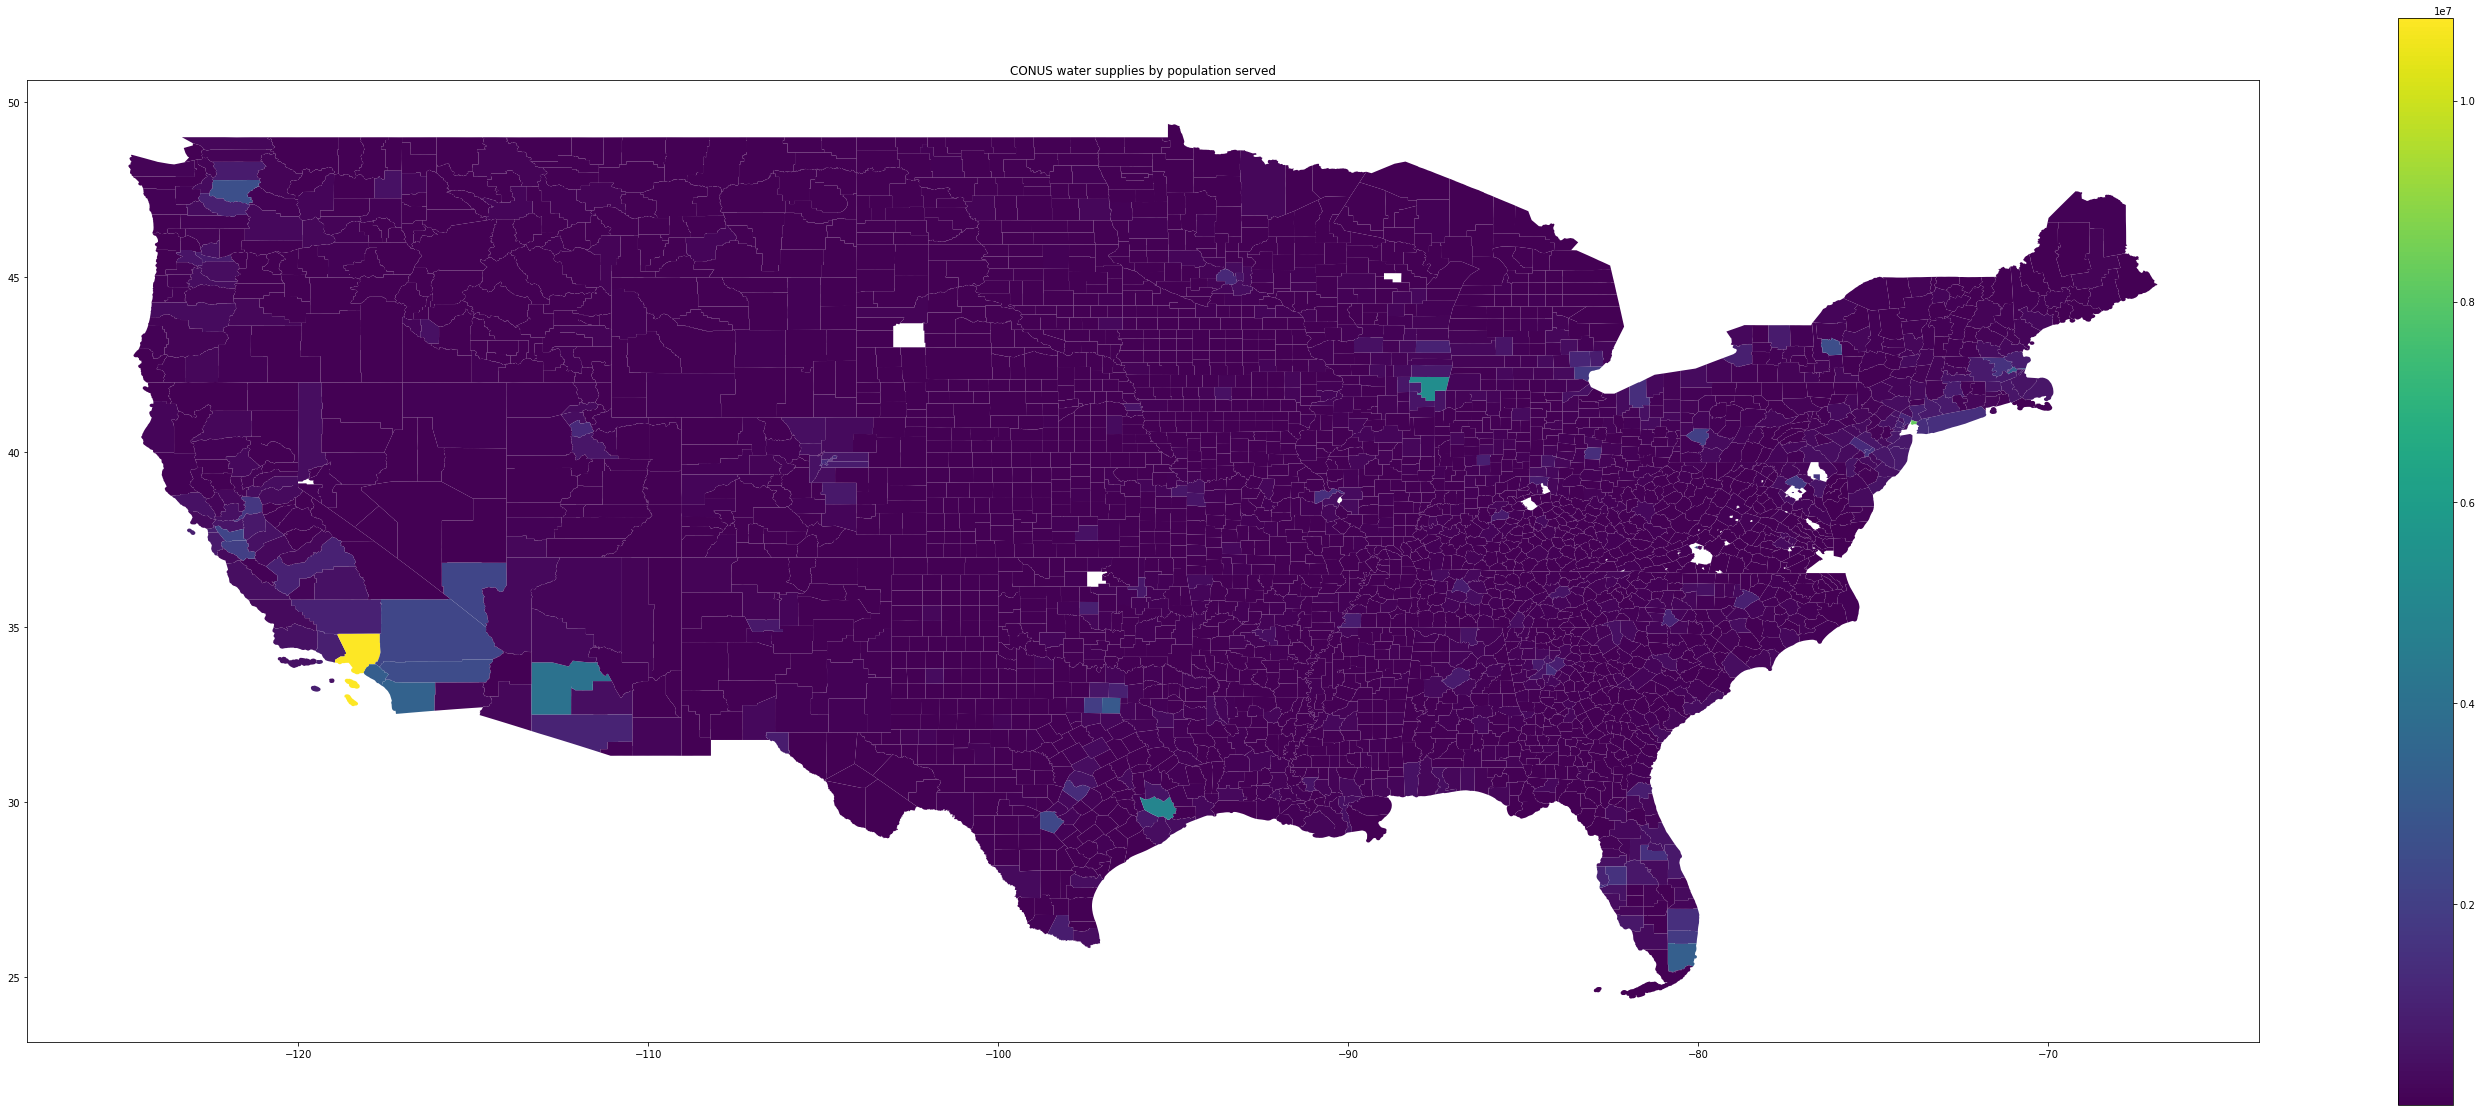

In [39]:
fig,ax = plt.subplots(figsize=(50,20))
gdf_USCountyWaterSupplies.cx[-125:-50, 20:70].plot("PopulationServed Count",ax=ax,legend="True")
ax.set_title("CONUS water supplies by population served")

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  fig.canvas.print_figure(bytes_io, **kw)


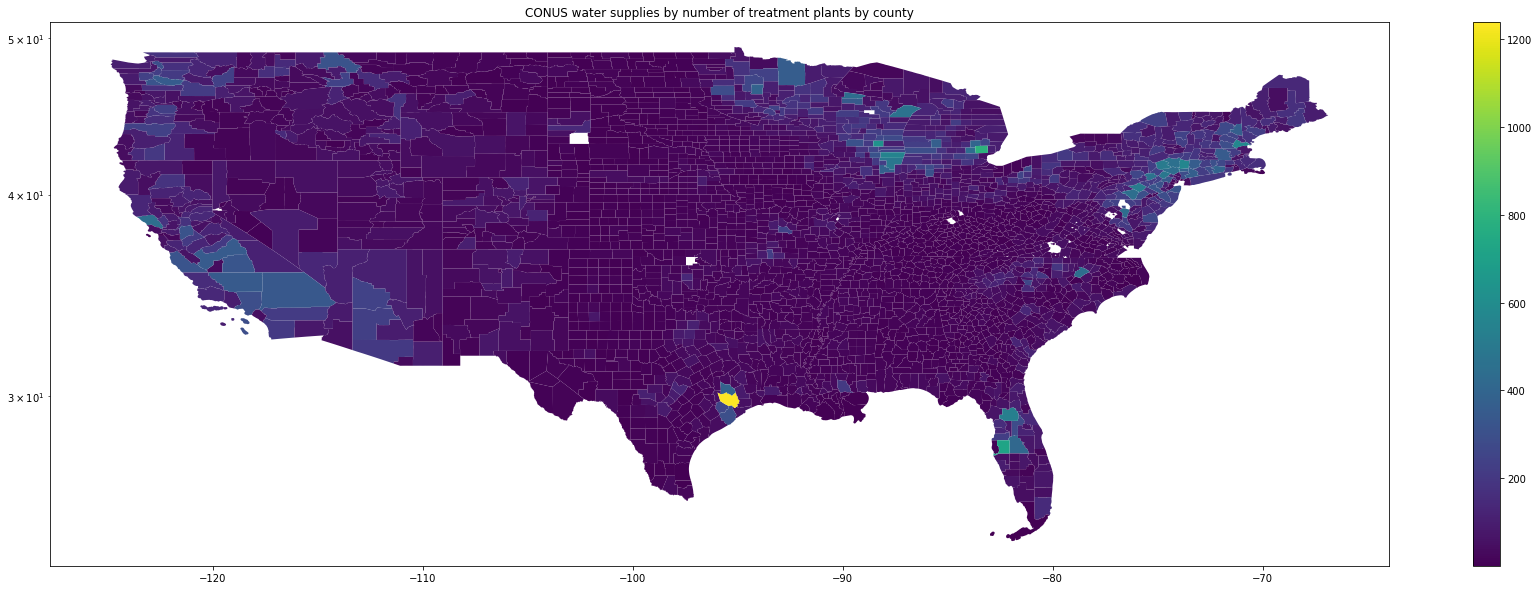

In [40]:
fig,ax = plt.subplots(figsize=(30,10))
gdf_USCountyWaterSupplies.cx[-125:-50, 20:60].plot("PWS ID",ax=ax,legend="True")
ax.set_title("CONUS water supplies by number of treatment plants by county")
ax.set_yscale("log")

Now decide on the population served thresholds based on operator numbers

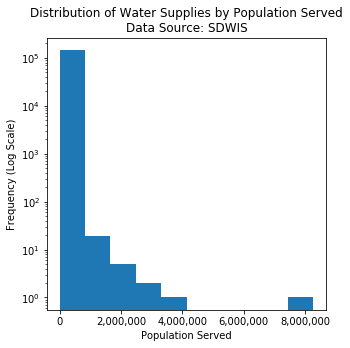

In [59]:
fig,ax = plt.subplots(figsize=(5,5))
df_AllStateWaterSupplies["PopulationServed Count"].plot(kind="hist",ax=ax)
ax.set_yscale("log")
ax.set_title("Distribution of Water Supplies by Population Served\nData Source: SDWIS")
ax.set_xlabel("Population Served")
ax.set_ylabel("Frequency (Log Scale)")
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}')) # https://stackoverflow.com/questions/25973581/how-do-i-format-axis-number-format-to-thousands-with-a-comma-in-matplotlib

Text(0, 0.5, 'Number of Supplies (Log Scale)')

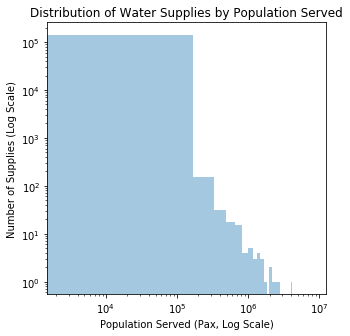

In [42]:
fig,ax = plt.subplots(figsize=(5,5))
sns.distplot(df_AllStateWaterSupplies["PopulationServed Count"],ax=ax,kde=False)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_title("Distribution of Water Supplies by Population Served")
ax.set_xlabel("Population Served (Pax, Log Scale)")
ax.set_ylabel("Number of Supplies (Log Scale)")

In [43]:
df_AllStateWaterSupplies.sort_values("PopulationServed Count",ascending=False)

,PWS ID,PWS Name,PWS Type,Primary Source,Counties Served,Cities Served,PopulationServed Count,Number of Facilities,Number of Violations,Number of Site Visits,State,Name,Postal Code,FIPS,Number of Counties Served,First County Served,County FIPS
87364,NY7003493,NEW YORK CITY SYSTEM,Community water system,Surface water,"Bronx, Kings, New York, Queens, Richmond",NEW YORK (C),8271000,162,24,174,NY,New York,NY,36,5,Bronx,36005
6030,CA1910067,"LOS ANGELES-CITY, DEPT. OF WATER & POWER",Community water system,Surface water,Los Angeles,LOS ANGELES,4085000,369,7,287,CA,California,CA,6,1,Los Angeles,06037
28854,IL0316000,CHICAGO,Community water system,Surface water,Cook,-,2700000,31,44,36,IL,Illinois,IL,17,1,Cook,17031
40985,MA6000000,MWRA,Community water system,Surface water,Suffolk,BOSTON,2550000,45,3,20,MA,Massachusetts,MA,25,1,Suffolk,25025
115058,TX1010013,CITY OF HOUSTON,Community water system,Surface water,Harris,-,2319603,1181,6,20,TX,Texas,TX,48,1,Harris,48201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48096,MI0002836,GRATIOT AREA WATER AUTHORITY,Community water system,Surface water,Gratiot,-,0,9,0,12,MI,Michigan,MI,26,1,Gratiot,26057
48099,MI0002838,GREAT LAKES WATER AUTHORITY,Community water system,Surface water,Wayne,DETROIT,0,10,0,26,MI,Michigan,MI,26,1,Wayne,26163
114487,TX0200497,BRAZOSPORT WATER AUTHORITY,Community water system,Surface water,Brazoria,-,0,9,8,13,TX,Texas,TX,48,1,Brazoria,48039
2170,AR0001077,FRANKLIN-SEBASTIAN PWA,Community water system,Surface water purchased,Sebastian,-,0,3,2,3,AR,Arkansas,AR,5,1,Sebastian,05131


In [44]:
df_AllStateWaterSupplies["Base 10 Population Served"] = np.log10(df_AllStateWaterSupplies["PopulationServed Count"])

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [45]:
gdf_USCountyWaterSupplies["Base 10 Population Served"] = np.log10(gdf_USCountyWaterSupplies["PopulationServed Count"])

Text(0.5, 1, 'COVID-19 INFRASTRUCTURE VULNERABILITY (PRELIMINARY)\nContact: Noah W. Garfinkle, garfink2@illinois.edu\nCONUS water supplies by population served (log scale)\nData Source:SDWIS')

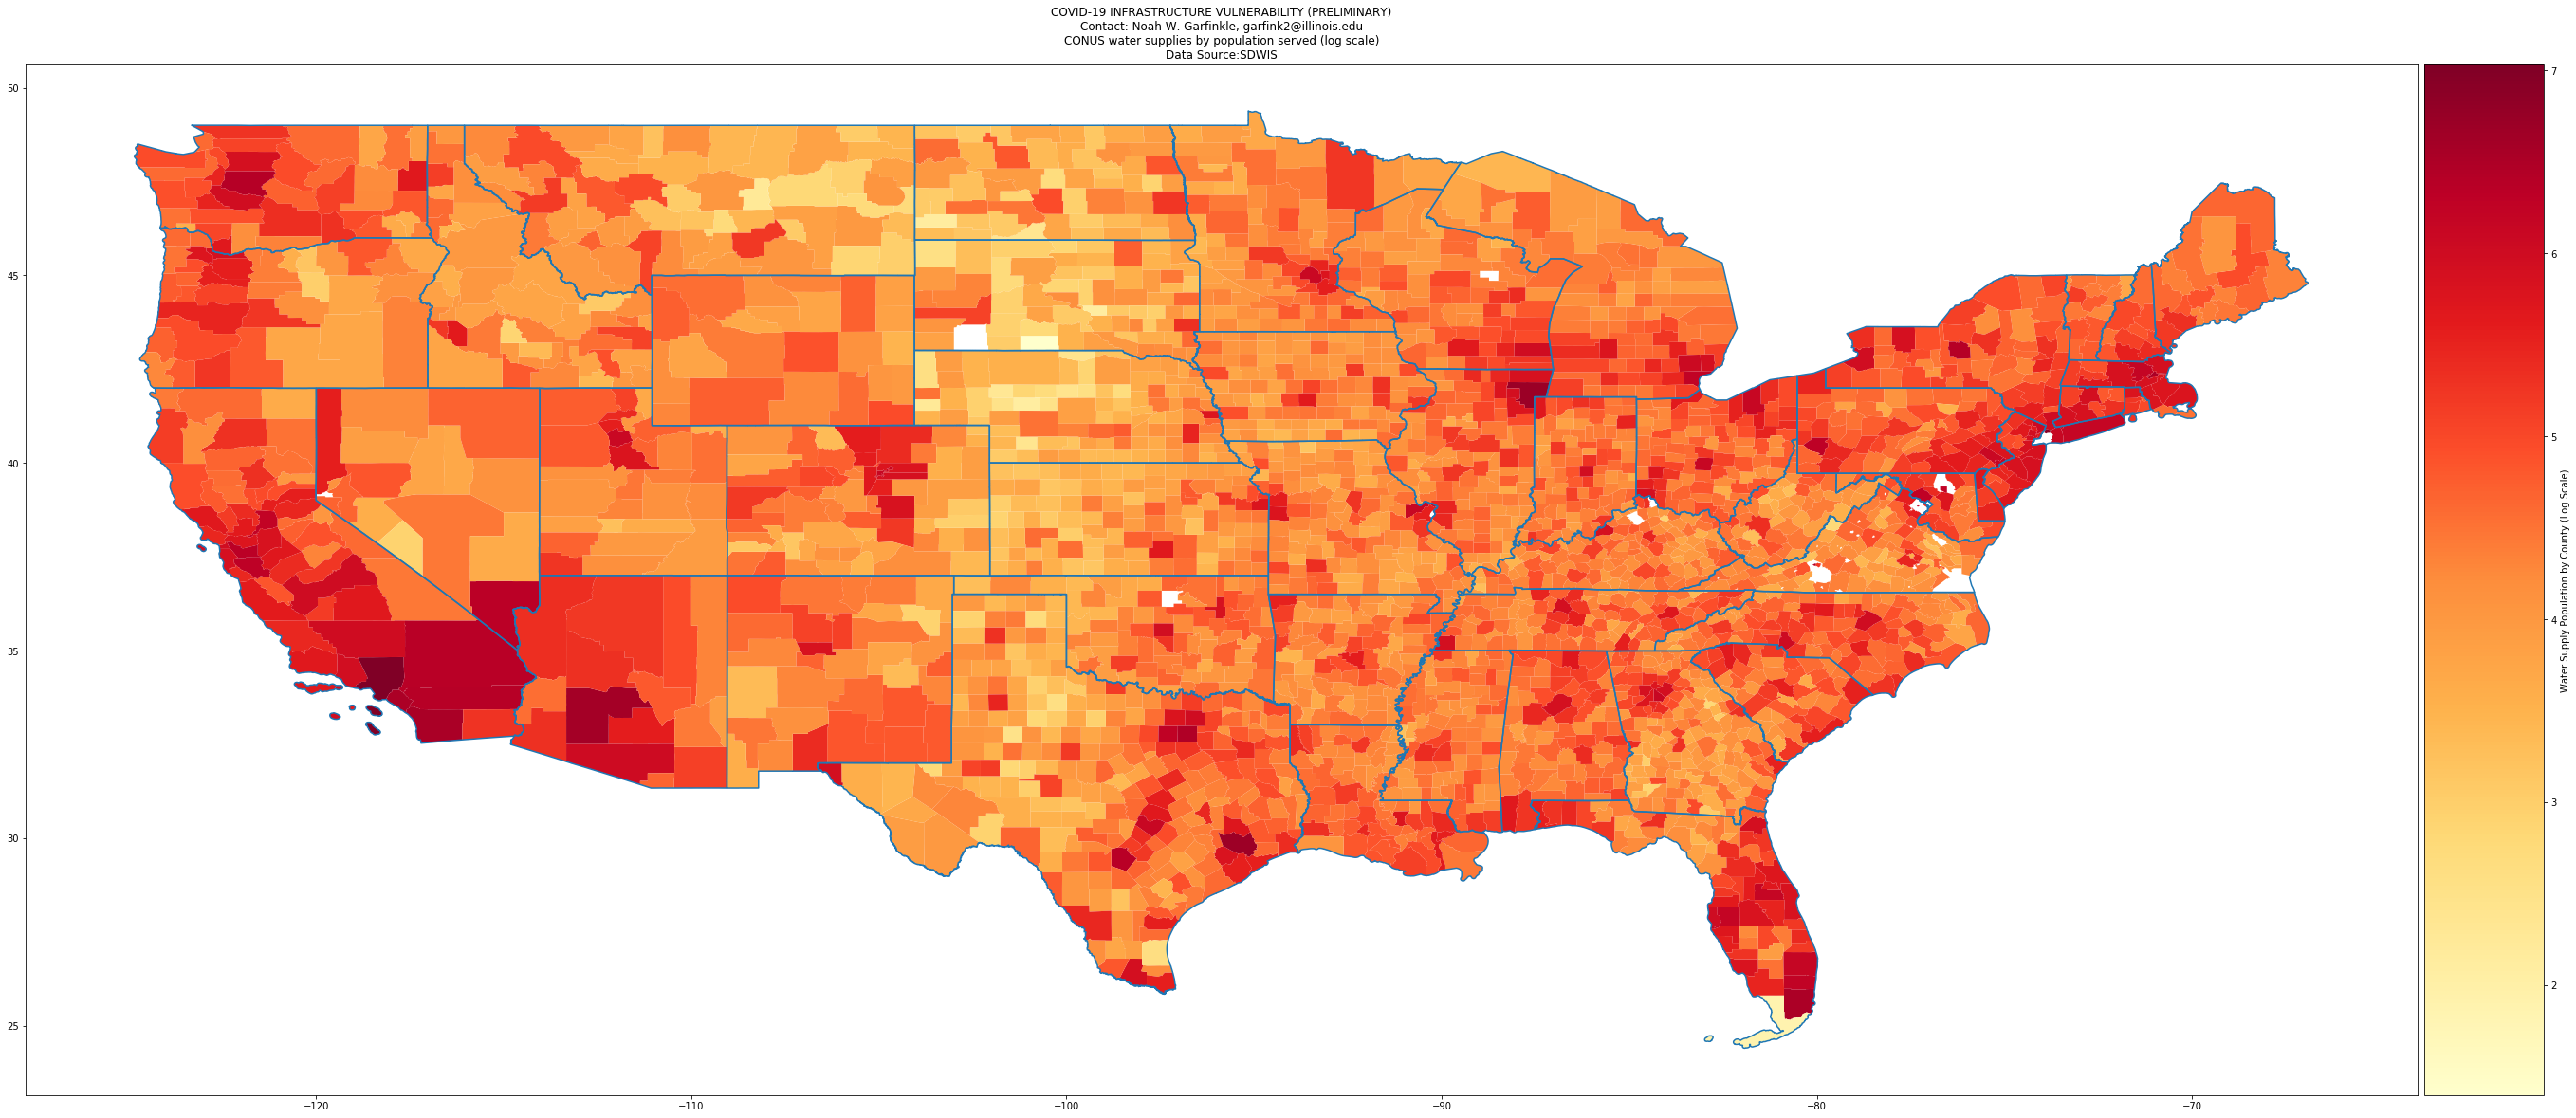

In [60]:
fig,ax = plt.subplots(figsize=(50,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
gdf_USCountyWaterSupplies.cx[-125:-50, 20:70].plot("Base 10 Population Served",ax=ax,cax=cax,legend="True",cmap="YlOrRd",
                                                  legend_kwds={'label': "Water Supply Population by County (Log Scale)"})
gdf_USStates.boundary.cx[-125:-50, 20:70].plot(ax=ax)
# ax.set_title("COVID-19 INFRASTRUCTURE VULNERABILITY (PRELIMINARY)\nContact: Noah W. Garfinkle, garfink2@illinois.edu, noah.w.garfinkle@usace.army.mil\nCONUS water supplies by population served (log scale)\nBlack Outlines are US Army Installations")
ax.set_title("COVID-19 INFRASTRUCTURE VULNERABILITY (PRELIMINARY)\nContact: Noah W. Garfinkle, garfink2@illinois.edu\nCONUS water supplies by population served (log scale)\nData Source:SDWIS")
# installationAreas.cx[-125:-50, 20:70].boundary.plot(ax=ax,color=None, edgecolor='black',label="US Army Installation")

Load employment data

In [47]:
df_BLSIndustries = pd.read_excel(excel_BLSIndustries) # https://data.bls.gov/cew/doc/titles/industry/industry_titles.htm

In [48]:
df_IndustriesToStartWith = df_BLSIndustries[df_BLSIndustries["High Level Include"]=="Yes"]

In [49]:
df_IndustriesToStartWith_PrettyNames = ["(2211): Power Generation and Supply Workforce",
                                        "(2212): Natural Gas Distribution Workorce",
                                        "(2213): Overall Water and Wastewater Workforce",
                                        "(22131): Water Sector Workforce",
                                        "(22132): Wastewater Sector Workforce",
                                        "(23711): Water and Wastewater Construction Workforce",
                                        "(23712): Oil and Gas Pipeline Construction Workforce",
                                        "(23713): Power and Communication Systems Construction Workforce",
                                        "(2373): Transportation Construction Workforce",
                                        "(92411): Air, Water, and Waste Government Administration Workforce",
                                        "(92613): Utility Regulation and Administration Workforce"
                                       ]

In [50]:
df_IndustriesToStartWith["Pretty Name"] = df_IndustriesToStartWith_PrettyNames

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [51]:
df_IndustriesToStartWith

,industry_code,industry_title,Include,High Level Include,Pretty Name
199,2211,NAICS 2211 Power generation and supply,Yes,Yes,(2211): Power Generation and Supply Workforce
213,2212,NAICS 2212 Natural gas distribution,Yes,Yes,(2212): Natural Gas Distribution Workorce
216,2213,"NAICS 2213 Water, sewage and other systems",Yes,Yes,(2213): Overall Water and Wastewater Workforce
217,22131,NAICS 22131 Water supply and irrigation systems,Yes,Yes,(22131): Water Sector Workforce
219,22132,NAICS 22132 Sewage treatment facilities,Yes,Yes,(22132): Wastewater Sector Workforce
238,23711,NAICS 23711 Water and sewer system construction,Yes,Yes,(23711): Water and Wastewater Construction Wor...
240,23712,NAICS 23712 Oil and gas pipeline construction,Yes,Yes,(23712): Oil and Gas Pipeline Construction Wor...
242,23713,NAICS 23713 Power and communication system con...,Yes,Yes,(23713): Power and Communication Systems Const...
247,2373,"NAICS 2373 Highway, street, and bridge constru...",Yes,Yes,(2373): Transportation Construction Workforce
2460,92411,"NAICS 92411 Air, water, and waste program admi...",Yes,Yes,"(92411): Air, Water, and Waste Government Admi..."


In [52]:
df_EmploymentData = pd.read_csv(csv_EmployementData2019Q1) # https://data.bls.gov/cew/doc/layouts/csv_quarterly_layout.htm

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [53]:
df_EmploymentData["area_fips"] = df_EmploymentData["area_fips"].astype("str")

In [54]:
df_EmploymentData.head()

,area_fips,own_code,industry_code,agglvl_code,size_code,year,qtr,disclosure_code,qtrly_estabs,month1_emplvl,month2_emplvl,month3_emplvl,total_qtrly_wages,taxable_qtrly_wages,qtrly_contributions,avg_wkly_wage,lq_disclosure_code,lq_qtrly_estabs,lq_month1_emplvl,lq_month2_emplvl,lq_month3_emplvl,lq_total_qtrly_wages,lq_taxable_qtrly_wages,lq_qtrly_contributions,lq_avg_wkly_wage,oty_disclosure_code,oty_qtrly_estabs_chg,oty_qtrly_estabs_pct_chg,oty_month1_emplvl_chg,oty_month1_emplvl_pct_chg,oty_month2_emplvl_chg,oty_month2_emplvl_pct_chg,oty_month3_emplvl_chg,oty_month3_emplvl_pct_chg,oty_total_qtrly_wages_chg,oty_total_qtrly_wages_pct_chg,oty_taxable_qtrly_wages_chg,oty_taxable_qtrly_wages_pct_chg,oty_qtrly_contributions_chg,oty_qtrly_contributions_pct_chg,oty_avg_wkly_wage_chg,oty_avg_wkly_wage_pct_chg
0,1000,0,10,50,0,2019,1,NaN,127988,1956476,1969122,1977658,24160364990,9849675204,119169491,944,NaN,1.00,1.00,1.00,1.00,1.00,1.0,1.0,1.00,NaN,2353,1.9,35545,1.9,32977,1.7,30223,1.6,1004646638,4.3,319152400,3.3,-5218828,-4.2,23,2.5
1,1000,0,10,50,0,2019,2,NaN,129541,1988655,1994384,1996581,23576562606,2588522394,32388053,910,NaN,1.00,1.00,1.00,1.00,1.00,1.0,1.0,1.00,NaN,3162,2.5,30587,1.6,31983,1.6,24604,1.2,1069251441,4.8,-1131343,0.0,-1846192,-5.4,29,3.3
2,1000,0,10,50,0,2019,3,NaN,130945,1985355,1992827,1989525,23766427185,1746589241,22396887,919,NaN,1.00,1.00,1.00,1.00,1.00,1.0,1.0,1.00,NaN,3453,2.7,28727,1.5,28502,1.5,22417,1.1,1193287670,5.3,24584731,1.4,-1553116,-6.5,34,3.8
3,1000,1,10,51,0,2019,1,NaN,1216,53337,53588,53497,1106955506,0,0,1592,NaN,1.61,1.42,1.42,1.42,1.86,0.0,0.0,1.31,NaN,24,2.0,791,1.5,1024,1.9,921,1.8,54267702,5.2,0,0.0,0,0.0,51,3.3
4,1000,1,10,51,0,2019,2,NaN,1217,53600,53690,53928,1121140925,0,0,1605,NaN,1.61,1.42,1.42,1.42,1.68,0.0,0.0,1.18,NaN,22,1.8,916,1.7,1114,2.1,1061,2.0,45900699,4.3,0,0.0,0,0.0,36,2.3


In [55]:
# Columns to track
fipsColumn = "area_fips"
industryCodeColumn = "industry_code"
nEstabColumn = "qtrly_estabs"
nEmployeesColumn = "month3_emplvl"
locationQuotientNEmployeesColumn = "lq_month3_emplvl"

In [56]:
df_employment_industry_subset.index

NameError: name 'df_employment_industry_subset' is not defined

In [ ]:
for i,row in df_IndustriesToStartWith.iterrows():
    industry_code = row["industry_code"]
    industry_title = row["industry_title"]
    df_employment_industry_subset = df_EmploymentData[(df_EmploymentData[industryCodeColumn] == str(industry_code)) & (df_EmploymentData["qtr"]==3)][[fipsColumn,industryCodeColumn,nEstabColumn,nEmployeesColumn,locationQuotientNEmployeesColumn]].groupby("area_fips").sum() # kludge, sum by area_fips to make sure unique
    df_employment_industry_subset.columns = [f"{industry_title}_{col}" for col in df_employment_industry_subset.columns]
    
    # create merge column
    df_employment_industry_subset["County FIPS INT"] = df_employment_industry_subset.index
    df_employment_industry_subset["County FIPS INT"] = pd.to_numeric(df_employment_industry_subset["County FIPS INT"],errors="coerce") # set non numeric to na
    df_employment_industry_subset.dropna(subset=['County FIPS INT'],inplace=True) # get rid of na
    df_employment_industry_subset["County FIPS INT"] = df_employment_industry_subset["County FIPS INT"].astype("int") # convert to int

    
    # create log scale
    for col in df_employment_industry_subset.columns:
        logColName = f"{col}_log10Scale"
        df_employment_industry_subset[logColName] = np.log10(df_employment_industry_subset[col])
    gdf_USCountyWaterSupplies = pd.merge(left=gdf_USCountyWaterSupplies,right=df_employment_industry_subset,left_on="County FIPS INT",right_on="County FIPS INT",how="left")

In [ ]:
gdf_USCountyWaterSupplies = gdf_USCountyWaterSupplies.replace(np.nan,0).replace(-np.inf,0)

In [ ]:
gdf_USCountyWaterSupplies.head()

In [ ]:
for i,row in df_IndustriesToStartWith.iterrows():
    industry_code = row["industry_code"]
    industry_title = row["industry_title"]
    pretty_name = row["Pretty Name"]
    fig,ax = plt.subplots(figsize=(50,20))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    columnToPlot = f"{industry_title}_{nEmployeesColumn}_log10Scale"
    gdf_USCountyWaterSupplies.cx[-125:-50, 20:70].plot(columnToPlot,
                                                       ax=ax,cax=cax,legend="True",cmap="YlOrRd")
    gdf_USStates.boundary.cx[-125:-50, 20:70].plot(ax=ax)
    ax.set_title(f"{pretty_name}\n{columnToPlot}\n$Log_{{10}}$ Scale")

In [ ]:
gdf_USCountyWaterSupplies["NAICS 2213 Water, sewage and other systems_month3_emplvl"].sum()

In [ ]:
gdf_USCountyWaterSupplies[gdf_USCountyWaterSupplies["NAME"] == "Los Angeles"]

Calculate utility operators per 1000 population

In [ ]:
for i,row in df_IndustriesToStartWith.iterrows():
    industry_code = row["industry_code"]
    industry_title = row["industry_title"]
    columnToCalculate = f"{industry_title}_{nEmployeesColumn}"
    newColumnName = f"{columnToCalculate}_Per1000"
    gdf_USCountyWaterSupplies[newColumnName] = gdf_USCountyWaterSupplies[columnToCalculate] / gdf_USCountyWaterSupplies["PopulationServed Count"] * 1000

Realize Florida is county is low because of remarkably low population.  As a kludge lets eliminate and replace with a lower "high" number of 10

In [ ]:
df_IndustriesToStartWith

In [ ]:
gdf_USCountyWaterSupplies.drop(['County FIPS INT_log10Scale_x','County FIPS INT_log10Scale_y'],axis=1,inplace=True)

In [ ]:
gdf_USCountyWaterSupplies.at[gdf_USCountyWaterSupplies[gdf_USCountyWaterSupplies[columnToUpdate]>9][columnToUpdate].index[0],columnToUpdate] = 5

In [ ]:
for i,row in df_IndustriesToStartWith.iterrows():
    industry_code = row["industry_code"]
    industry_title = row["industry_title"]
    pretty_name = row["Pretty Name"]
    fig,ax = plt.subplots(figsize=(50,20))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    columnToPlot = f"{industry_title}_{nEmployeesColumn}_Per1000"
    gdf_USCountyWaterSupplies.cx[-125:-50, 20:70].plot(columnToPlot,
                                                       ax=ax,cax=cax,legend="True",cmap="YlOrRd")
    installationAreas.cx[-125:-50, 20:70].boundary.plot(ax=ax,color=None, edgecolor='black',label="US Army Installation") # https://gis.stackexchange.com/questions/299379/superposing-two-plots-with-geopandas-with-non-fill-colours-in-one-of-them
    gdf_USStates.boundary.cx[-125:-50, 20:70].plot(ax=ax)
    ax.set_title(f"COVID-19 INFRASTRUCTURE VULNERABILITY (PRELIMINARY)\nContact: Noah W. Garfinkle, garfink2@illinois.edu, noah.w.garfinkle@usace.army.mil\n{pretty_name} Per 1000 Water Served\nCounty Level, Black Outlines of US Army Installations")

In [ ]:
for i,row in df_IndustriesToStartWith.iterrows():
    industry_code = row["industry_code"]
    industry_title = row["industry_title"]
    pretty_name = row["Pretty Name"]
    fig,ax = plt.subplots(figsize=(5,5))
    columnToPlot = f"{industry_title}_{nEmployeesColumn}_Per1000"
    ax.hist(gdf_USCountyWaterSupplies[columnToPlot],bins=100)
    ax.set_yscale("log")
    ax.set_xscale("log")
#     ax.set_title(f"COVID-19 INFRASTRUCTURE VULNERABILITY (PRELIMINARY)\nContact: Noah W. Garfinkle, garfink2@illinois.edu, noah.w.garfinkle@usace.army.mil\n{pretty_name} Per 1000 Water Served\n$log_{{10}}$ Scale, County Level")
    ax.set_title(f"COVID-19 INFRASTRUCTURE VULNERABILITY (PRELIMINARY)\n{pretty_name} Per 1000 Water Served\n$log_{{10}}$ Scale, County Level")
    ax.set_ylabel("Number of Observations (Log Scale)")
    ax.set_xlabel("Count Per 1000 Water Service")

In [ ]:
gdf_USCountyWaterSupplies.head(30)